# Demand Forecasting for Dairy Supply and Inventory
This notebook provides a backend workflow for forecasting demand and optimizing inventory in a dairy supply chain. The goal is to maximize utilization of processing, packaging, and storage capacities, reduce costs, and improve ROI by predicting demand and optimizing inventory levels.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load and Inspect Dataset
df = pd.read_csv('Country Delight Diary Sales and Inventory Dataset (1).csv')
df.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Bihar,351.482551,91.840120,Medium,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,...,06-10-2019,12-09-2019,41.845226,25.835327,223.449663,Karnataka,Retail,399.380088,53.946619,125.168698
1,Rajasthan,770.990435,25.034385,Large,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,...,22-12-2022,19-03-2023,414.997449,55.841265,22187.873240,Uttar Pradesh,Wholesale,183.852626,83.565770,113.244520
2,Chandigarh,245.545777,58.334806,Small,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,...,07-12-2020,10-12-2020,39.629634,53.428623,462.729412,Bihar,Retail,88.096419,74.964513,170.349551
3,Chandigarh,710.714831,38.758725,Small,15-06-2019,8.546638,Ghee,Dodla Dairy,669.336674,32.007418,...,25-05-2019,05-06-2019,406.209363,36.572210,16363.149300,Jharkhand,Wholesale,200.374813,90.577706,53.537173
4,Delhi,200.576940,85.318326,Small,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,...,24-08-2021,22-12-2021,349.192441,17.713561,8430.990309,Tamil Nadu,Retail,303.146586,64.424322,164.690946


In [3]:
# Remove rows with specific brand names
brands_to_remove = [
    'Britannia Industries', 'Dynamix Dairies', 'Passion Cheese',
    'Parag Milk Foods', 'Dodla Dairy', 'Palle2patnam', 'Warana'
]
df = df[~df['Brand'].isin(brands_to_remove)]

In [4]:
# Remove unnecessary columns
drop_cols = ['Location', 'Total Land Area (acres)', 'Number of Cows', 'Farm Size', 'Storage Condition', 'Expiration Date']
df = df.drop(columns=drop_cols, errors='ignore')
print('Remaining columns:', df.columns.tolist())

Remaining columns: ['Date', 'Product ID', 'Product Name', 'Brand', 'Quantity (liters/kg)', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Production Date', 'Quantity Sold (liters/kg)', 'Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Customer Location', 'Sales Channel', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)', 'Reorder Quantity (liters/kg)']


In [5]:
# Inspect dataset columns and sample data
print('Columns:', df.columns.tolist())
df.head()

Columns: ['Date', 'Product ID', 'Product Name', 'Brand', 'Quantity (liters/kg)', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Production Date', 'Quantity Sold (liters/kg)', 'Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Customer Location', 'Sales Channel', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)', 'Reorder Quantity (liters/kg)']


,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,7895.403814,6.784471,06-10-2019,41.845226,25.835327,223.449663,Karnataka,Retail,399.380088,53.946619,125.168698
1,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,23376.255600,34.580936,22-12-2022,414.997449,55.841265,22187.873240,Uttar Pradesh,Wholesale,183.852626,83.565770,113.244520
2,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,6814.191021,22.133369,07-12-2020,39.629634,53.428623,462.729412,Bihar,Retail,88.096419,74.964513,170.349551
4,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,38604.645590,112.775516,24-08-2021,349.192441,17.713561,8430.990309,Tamil Nadu,Retail,303.146586,64.424322,164.690946
5,29-09-2019,10.000000,Ghee,Amul,412.179982,95.169570,55138.034590,140.038451,20-09-2019,32.633105,92.244630,8505.493899,Kerala,Retail,432.830203,90.584562,135.949577


In [6]:
# Data Cleaning and Preprocessing
#Check for missing values, data types, and perform necessary cleaning to prepare the dataset for modeling.

In [7]:
# Data Cleaning and Preprocessing
print('Missing values per column:')
print(df.isnull().sum())
print('\nData types:')
print(df.dtypes)

# Example: Fill missing values (customize as needed)
df = df.fillna(method='ffill')

df.describe()

Missing values per column:
Date                                   0
Product ID                             0
Product Name                           0
Brand                                  0
Quantity (liters/kg)                   0
Price per Unit                         0
Total Value                            0
Shelf Life (days)                      0
Production Date                        0
Quantity Sold (liters/kg)              0
Price per Unit (sold)                  0
Approx. Total Revenue(INR)             0
Customer Location                      0
Sales Channel                          0
Quantity in Stock (liters/kg)          0
Minimum Stock Threshold (liters/kg)    0
Reorder Quantity (liters/kg)           0
dtype: int64

Data types:
Date                                    object
Product ID                             float64
Product Name                            object
Brand                                   object
Quantity (liters/kg)                   float64
Price per Unit 

C:\Users\SAUMIL\AppData\Local\Temp\ipykernel_18828\3054796955.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Product ID,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
count,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000,95652.000000
mean,5.518688,499.958975,54.572553,27331.841918,29.226580,249.654609,54.571312,13691.032624,253.949025,55.873131,108.878376
std,2.823400,291.348051,26.154341,21802.931250,30.558671,217.970111,26.501180,14657.788152,225.259193,26.491091,51.852658
min,1.000000,1.170000,10.030000,42.516500,1.000000,1.000000,5.210000,12.540000,0.000000,10.020000,20.020000
25%,3.055996,253.760594,32.212721,9828.635551,9.983514,73.033886,32.329660,3202.201528,69.677135,32.915363,64.704876
50%,5.570292,498.904117,54.249649,21958.013105,20.451898,191.500510,54.068244,8654.172893,191.659919,56.560027,108.326503
75%,7.973278,749.765728,77.098218,40851.462650,33.192010,376.354491,77.046452,19565.571710,390.033507,78.908982,153.073834
max,10.000000,999.930000,99.990000,99036.369600,150.000000,960.000000,104.510000,89108.900000,976.000000,99.990000,199.950000


In [8]:
# Display all unique values and their count for a specific column
col = "Product Name" 
unique_vals = df[col].unique()
print("Unique values:", unique_vals)
print("Total number of unique values:", len(unique_vals))

Unique values: ['Cheese' 'Curd' 'Butter' 'Ghee' 'Milk' 'Paneer' 'Lassi' 'Buttermilk'
 'Ice Cream' 'Yogurt']
Total number of unique values: 10


In [9]:
# Display all unique values and their count for a specific column
col = "Brand" 
unique_vals = df[col].unique()
print("Unique values:", unique_vals)
print("Total number of unique values:", len(unique_vals))

Unique values: ['Mother Dairy' 'Raj' 'Amul' 'Sudha']
Total number of unique values: 4


In [10]:
# Convert specified columns from float to integer
to_convert = ["Shelf Life (days)"]  # Replace with your column names
df[to_convert] = df[to_convert].astype(int)
print(df[to_convert].dtypes)
df.head()

Shelf Life (days)    int32
dtype: object


,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,7895.403814,6,06-10-2019,41.845226,25.835327,223.449663,Karnataka,Retail,399.380088,53.946619,125.168698
1,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,23376.255600,34,22-12-2022,414.997449,55.841265,22187.873240,Uttar Pradesh,Wholesale,183.852626,83.565770,113.244520
2,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,6814.191021,22,07-12-2020,39.629634,53.428623,462.729412,Bihar,Retail,88.096419,74.964513,170.349551
4,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,38604.645590,112,24-08-2021,349.192441,17.713561,8430.990309,Tamil Nadu,Retail,303.146586,64.424322,164.690946
5,29-09-2019,10.000000,Ghee,Amul,412.179982,95.169570,55138.034590,140,20-09-2019,32.633105,92.244630,8505.493899,Kerala,Retail,432.830203,90.584562,135.949577


In [11]:
# Recalculate Total Value as Quantity (liters/kg) * Price per Unit
df['Quantity in Stock (liters/kg)'] = df['Quantity (liters/kg)'] - df['Quantity Sold (liters/kg)']

df.head()

,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,7895.403814,6,06-10-2019,41.845226,25.835327,223.449663,Karnataka,Retail,432.610176,53.946619,125.168698
1,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,23376.255600,34,22-12-2022,414.997449,55.841265,22187.873240,Uttar Pradesh,Wholesale,183.433692,83.565770,113.244520
2,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,6814.191021,22,07-12-2020,39.629634,53.428623,462.729412,Bihar,Retail,234.325986,74.964513,170.349551
4,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,38604.645590,112,24-08-2021,349.192441,17.713561,8430.990309,Tamil Nadu,Retail,449.061116,64.424322,164.690946
5,29-09-2019,10.000000,Ghee,Amul,412.179982,95.169570,55138.034590,140,20-09-2019,32.633105,92.244630,8505.493899,Kerala,Retail,379.546878,90.584562,135.949577


In [12]:
# Recalculate Total Value as Quantity (liters/kg) * Price per Unit
df['Total Value'] = df['Quantity (liters/kg)'] * df['Price per Unit']

df.head()

,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,12227.972793,6,06-10-2019,41.845226,25.835327,223.449663,Karnataka,Retail,432.610176,53.946619,125.168698
1,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,36662.719579,34,22-12-2022,414.997449,55.841265,22187.873240,Uttar Pradesh,Wholesale,183.433692,83.565770,113.244520
2,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,15009.424375,22,07-12-2020,39.629634,53.428623,462.729412,Bihar,Retail,234.325986,74.964513,170.349551
4,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,14379.159594,112,24-08-2021,349.192441,17.713561,8430.990309,Tamil Nadu,Retail,449.061116,64.424322,164.690946
5,29-09-2019,10.000000,Ghee,Amul,412.179982,95.169570,39226.991586,140,20-09-2019,32.633105,92.244630,8505.493899,Kerala,Retail,379.546878,90.584562,135.949577


In [13]:
# Recalculate Total Value as Quantity (liters/kg) * Price per Unit
df['Approx. Total Revenue(INR)'] = df['Quantity Sold (liters/kg)'] * df['Price per Unit (sold)']

df.head()

,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,474.455402,25.772650,12227.972793,6,06-10-2019,41.845226,25.835327,1081.085095,Karnataka,Retail,432.610176,53.946619,125.168698
1,28-12-2022,8.628970,Curd,Raj,598.431141,61.264725,36662.719579,34,22-12-2022,414.997449,55.841265,23173.982316,Uttar Pradesh,Wholesale,183.433692,83.565770,113.244520
2,12-01-2021,3.600437,Butter,Amul,273.955620,54.787795,15009.424375,22,07-12-2020,39.629634,53.428623,2117.356759,Bihar,Retail,234.325986,74.964513,170.349551
4,24-09-2021,8.732560,Butter,Sudha,798.253557,18.013273,14379.159594,112,24-08-2021,349.192441,17.713561,6185.441550,Tamil Nadu,Retail,449.061116,64.424322,164.690946
5,29-09-2019,10.000000,Ghee,Amul,412.179982,95.169570,39226.991586,140,20-09-2019,32.633105,92.244630,3010.228683,Kerala,Retail,379.546878,90.584562,135.949577


In [14]:
import numpy as np

# Define product types for each measurement
kg_products = ['cheese', 'curd', 'butter', 'paneer', 'yogurt']
liter_products = ['ghee', 'milk', 'lassi', 'Buttermilk', 'ice cream']

# Create new columns for quantity in liters and kg
df['Quantity (liters)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(liter_products)),
    df['Quantity (liters/kg)'],
    '-'
)
df['Quantity (kg)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(kg_products)),
    df['Quantity (liters/kg)'],
    '-'
)

# Replace '-' with np.nan or 0
df['Quantity (liters)'] = pd.to_numeric(df['Quantity (liters)'], errors='coerce').fillna(0)
df['Quantity (kg)'] = pd.to_numeric(df['Quantity (kg)'], errors='coerce').fillna(0)

# Optional: Display the first few rows to verify
df[['Product Name', 'Quantity (liters/kg)', 'Quantity (liters)', 'Quantity (kg)']].head()

,Product Name,Quantity (liters/kg),Quantity (liters),Quantity (kg)
0,Cheese,474.455402,0.000000,474.455402
1,Curd,598.431141,0.000000,598.431141
2,Butter,273.955620,0.000000,273.955620
4,Butter,798.253557,0.000000,798.253557
5,Ghee,412.179982,412.179982,0.000000


In [15]:
# Define product types for each measurement
kg_products = ['cheese', 'curd', 'butter', 'paneer', 'yogurt']
liter_products = ['ghee', 'milk', 'lassi', 'Buttermilk', 'ice cream']

# Create new columns for quantity in liters and kg
df['Quantity Sold (liters)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(liter_products)),
    df['Quantity Sold (liters/kg)'],
    '-'
)
df['Quantity Sold (kg)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(kg_products)),
    df['Quantity Sold (liters/kg)'],
    '-'
)

# Replace '-' with np.nan or 0
df['Quantity Sold (liters)'] = pd.to_numeric(df['Quantity Sold (liters)'], errors='coerce').fillna(0)
df['Quantity Sold (kg)'] = pd.to_numeric(df['Quantity Sold (kg)'], errors='coerce').fillna(0)

# Optional: Display the first few rows to verify
df[['Product Name', 'Quantity Sold (liters/kg)', 'Quantity Sold (liters)', 'Quantity Sold (kg)']].head()

,Product Name,Quantity Sold (liters/kg),Quantity Sold (liters),Quantity Sold (kg)
0,Cheese,41.845226,0.000000,41.845226
1,Curd,414.997449,0.000000,414.997449
2,Butter,39.629634,0.000000,39.629634
4,Butter,349.192441,0.000000,349.192441
5,Ghee,32.633105,32.633105,0.000000


In [16]:
# Define product types for each measurement
kg_products = ['cheese', 'curd', 'butter', 'paneer', 'yogurt']
liter_products = ['ghee', 'milk', 'lassi', 'Buttermilk', 'ice cream']

# Create new columns for quantity in liters and kg
df['Quantity in Stock (liters)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(liter_products)),
    df['Quantity in Stock (liters/kg)'],
    '-'
)
df['Quantity in Stock (kg)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(kg_products)),
    df['Quantity in Stock (liters/kg)'],
    '-'
)

# Replace '-' with np.nan or 0
df['Quantity in Stock (liters)'] = pd.to_numeric(df['Quantity in Stock (liters)'], errors='coerce').fillna(0)
df['Quantity in Stock (kg)'] = pd.to_numeric(df['Quantity in Stock (kg)'], errors='coerce').fillna(0)

# Optional: Display the first few rows to verify
df[['Product Name', 'Quantity in Stock (liters/kg)', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)']].head()

,Product Name,Quantity in Stock (liters/kg),Quantity in Stock (liters),Quantity in Stock (kg)
0,Cheese,432.610176,0.000000,432.610176
1,Curd,183.433692,0.000000,183.433692
2,Butter,234.325986,0.000000,234.325986
4,Butter,449.061116,0.000000,449.061116
5,Ghee,379.546878,379.546878,0.000000


In [17]:
# Define product types for each measurement
kg_products = ['cheese', 'curd', 'butter', 'paneer', 'yogurt']
liter_products = ['ghee', 'milk', 'lassi', 'Buttermilk', 'ice cream']

# Create new columns for quantity in liters and kg
df['Minimum Stock Threshold (liters)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(liter_products)),
    df['Minimum Stock Threshold (liters/kg)'],
    '-'
)
df['Minimum Stock Threshold (kg)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(kg_products)),
    df['Minimum Stock Threshold (liters/kg)'],
    '-'
)

# Replace '-' with np.nan or 0
df['Minimum Stock Threshold (liters)'] = pd.to_numeric(df['Minimum Stock Threshold (liters)'], errors='coerce').fillna(0)
df['Minimum Stock Threshold (kg)'] = pd.to_numeric(df['Minimum Stock Threshold (kg)'], errors='coerce').fillna(0)

# Optional: Display the first few rows to verify
df[['Product Name', 'Minimum Stock Threshold (liters/kg)', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)']].head()

,Product Name,Minimum Stock Threshold (liters/kg),Minimum Stock Threshold (liters),Minimum Stock Threshold (kg)
0,Cheese,53.946619,0.000000,53.946619
1,Curd,83.565770,0.000000,83.565770
2,Butter,74.964513,0.000000,74.964513
4,Butter,64.424322,0.000000,64.424322
5,Ghee,90.584562,90.584562,0.000000


In [18]:
# Define product types for each measurement
kg_products = ['cheese', 'curd', 'butter', 'paneer', 'yogurt']
liter_products = ['ghee', 'milk', 'lassi', 'Buttermilk', 'ice cream']

# Create new columns for quantity in liters and kg
df['Reorder Quantity (liters)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(liter_products)),
    df['Reorder Quantity (liters/kg)'],
    '-'
)
df['Reorder Quantity (kg)'] = np.where(
    df['Product Name'].str.lower().str.contains('|'.join(kg_products)),
    df['Reorder Quantity (liters/kg)'],
    '-'
)

# Replace '-' with np.nan or 0
df['Reorder Quantity (liters)'] = pd.to_numeric(df['Reorder Quantity (liters)'], errors='coerce').fillna(0)
df['Reorder Quantity (kg)'] = pd.to_numeric(df['Reorder Quantity (kg)'], errors='coerce').fillna(0)

# Optional: Display the first few rows to verify
df[['Product Name', 'Reorder Quantity (liters/kg)', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)']].head()

,Product Name,Reorder Quantity (liters/kg),Reorder Quantity (liters),Reorder Quantity (kg)
0,Cheese,125.168698,0.000000,125.168698
1,Curd,113.244520,0.000000,113.244520
2,Butter,170.349551,0.000000,170.349551
4,Butter,164.690946,0.000000,164.690946
5,Ghee,135.949577,135.949577,0.000000


In [19]:
# Remove the original 'Quantity (liters/kg)' column
df = df.drop(columns=['Quantity (liters/kg)', 'Reorder Quantity (liters/kg)', 'Reorder Quantity (liters/kg)', 'Quantity in Stock (liters/kg)', 'Quantity Sold (liters/kg)', 'Minimum Stock Threshold (liters/kg)'], errors='ignore')
df.head()

,Date,Product ID,Product Name,Brand,Price per Unit,Total Value,Shelf Life (days),Production Date,Price per Unit (sold),Approx. Total Revenue(INR),...,Quantity (liters),Quantity (kg),Quantity Sold (liters),Quantity Sold (kg),Quantity in Stock (liters),Quantity in Stock (kg),Minimum Stock Threshold (liters),Minimum Stock Threshold (kg),Reorder Quantity (liters),Reorder Quantity (kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,25.772650,12227.972793,6,06-10-2019,25.835327,1081.085095,...,0.000000,474.455402,0.000000,41.845226,0.000000,432.610176,0.000000,53.946619,0.000000,125.168698
1,28-12-2022,8.628970,Curd,Raj,61.264725,36662.719579,34,22-12-2022,55.841265,23173.982316,...,0.000000,598.431141,0.000000,414.997449,0.000000,183.433692,0.000000,83.565770,0.000000,113.244520
2,12-01-2021,3.600437,Butter,Amul,54.787795,15009.424375,22,07-12-2020,53.428623,2117.356759,...,0.000000,273.955620,0.000000,39.629634,0.000000,234.325986,0.000000,74.964513,0.000000,170.349551
4,24-09-2021,8.732560,Butter,Sudha,18.013273,14379.159594,112,24-08-2021,17.713561,6185.441550,...,0.000000,798.253557,0.000000,349.192441,0.000000,449.061116,0.000000,64.424322,0.000000,164.690946
5,29-09-2019,10.000000,Ghee,Amul,95.169570,39226.991586,140,20-09-2019,92.244630,3010.228683,...,412.179982,0.000000,32.633105,0.000000,379.546878,0.000000,90.584562,0.000000,135.949577,0.000000


In [20]:
df.loc[df['Product Name'].str.lower().str.contains('buttermilk'), 'Quantity (kg)'] = 0.0000

df[df['Product Name'].str.lower().str.contains('buttermilk')][['Product Name', 'Quantity (liters)', 'Quantity (kg)']]

,Product Name,Quantity (liters),Quantity (kg)
17,Buttermilk,910.795019,0.0
43,Buttermilk,334.019712,0.0
47,Buttermilk,241.507078,0.0
50,Buttermilk,635.793618,0.0
51,Buttermilk,520.956067,0.0
...,...,...,...
122956,Buttermilk,521.228078,0.0
122966,Buttermilk,975.335714,0.0
122967,Buttermilk,999.930000,0.0
122970,Buttermilk,496.802983,0.0


In [21]:
# Set Quantity Sold (kg) to 0.0000 for buttermilk rows
df.loc[df['Product Name'].str.lower().str.contains('buttermilk'), 'Quantity Sold (kg)'] = 0.0000

df[df['Product Name'].str.lower().str.contains('buttermilk')][['Product Name', 'Quantity Sold (liters)', 'Quantity Sold (kg)']]

,Product Name,Quantity Sold (liters),Quantity Sold (kg)
17,Buttermilk,269.656242,0.0
43,Buttermilk,207.353985,0.0
47,Buttermilk,170.170710,0.0
50,Buttermilk,166.740198,0.0
51,Buttermilk,187.031732,0.0
...,...,...,...
122956,Buttermilk,271.369349,0.0
122966,Buttermilk,871.934774,0.0
122967,Buttermilk,336.515239,0.0
122970,Buttermilk,60.253376,0.0


In [22]:
df.loc[df['Product Name'].str.lower().str.contains('buttermilk'), 'Quantity in Stock (kg)'] = 0.0000

df[df['Product Name'].str.lower().str.contains('buttermilk')][['Product Name', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)']]

,Product Name,Quantity in Stock (liters),Quantity in Stock (kg)
17,Buttermilk,641.138777,0.0
43,Buttermilk,126.665727,0.0
47,Buttermilk,71.336368,0.0
50,Buttermilk,469.053419,0.0
51,Buttermilk,333.924335,0.0
...,...,...,...
122956,Buttermilk,249.858729,0.0
122966,Buttermilk,103.400940,0.0
122967,Buttermilk,663.414761,0.0
122970,Buttermilk,436.549607,0.0


In [23]:
df.loc[df['Product Name'].str.lower().str.contains('buttermilk'), 'Minimum Stock Threshold (kg)'] = 0.0000

df[df['Product Name'].str.lower().str.contains('buttermilk')][['Product Name', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)']]

,Product Name,Minimum Stock Threshold (liters),Minimum Stock Threshold (kg)
17,Buttermilk,86.345371,0.0
43,Buttermilk,82.797733,0.0
47,Buttermilk,10.020000,0.0
50,Buttermilk,27.106772,0.0
51,Buttermilk,64.463282,0.0
...,...,...,...
122956,Buttermilk,67.262639,0.0
122966,Buttermilk,84.350071,0.0
122967,Buttermilk,74.297489,0.0
122970,Buttermilk,49.434942,0.0


In [24]:
df.loc[df['Product Name'].str.lower().str.contains('buttermilk'), 'Reorder Quantity (kg)'] = 0.0000

df[df['Product Name'].str.lower().str.contains('buttermilk')][['Product Name', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)']]

,Product Name,Reorder Quantity (liters),Reorder Quantity (kg)
17,Buttermilk,58.864503,0.0
43,Buttermilk,169.483857,0.0
47,Buttermilk,151.843731,0.0
50,Buttermilk,134.286509,0.0
51,Buttermilk,173.501577,0.0
...,...,...,...
122956,Buttermilk,26.204192,0.0
122966,Buttermilk,109.075485,0.0
122967,Buttermilk,72.254577,0.0
122970,Buttermilk,58.243095,0.0


In [25]:
df.head()

,Date,Product ID,Product Name,Brand,Price per Unit,Total Value,Shelf Life (days),Production Date,Price per Unit (sold),Approx. Total Revenue(INR),...,Quantity (liters),Quantity (kg),Quantity Sold (liters),Quantity Sold (kg),Quantity in Stock (liters),Quantity in Stock (kg),Minimum Stock Threshold (liters),Minimum Stock Threshold (kg),Reorder Quantity (liters),Reorder Quantity (kg)
0,19-10-2019,4.541257,Cheese,Mother Dairy,25.772650,12227.972793,6,06-10-2019,25.835327,1081.085095,...,0.000000,474.455402,0.000000,41.845226,0.000000,432.610176,0.000000,53.946619,0.000000,125.168698
1,28-12-2022,8.628970,Curd,Raj,61.264725,36662.719579,34,22-12-2022,55.841265,23173.982316,...,0.000000,598.431141,0.000000,414.997449,0.000000,183.433692,0.000000,83.565770,0.000000,113.244520
2,12-01-2021,3.600437,Butter,Amul,54.787795,15009.424375,22,07-12-2020,53.428623,2117.356759,...,0.000000,273.955620,0.000000,39.629634,0.000000,234.325986,0.000000,74.964513,0.000000,170.349551
4,24-09-2021,8.732560,Butter,Sudha,18.013273,14379.159594,112,24-08-2021,17.713561,6185.441550,...,0.000000,798.253557,0.000000,349.192441,0.000000,449.061116,0.000000,64.424322,0.000000,164.690946
5,29-09-2019,10.000000,Ghee,Amul,95.169570,39226.991586,140,20-09-2019,92.244630,3010.228683,...,412.179982,0.000000,32.633105,0.000000,379.546878,0.000000,90.584562,0.000000,135.949577,0.000000


In [26]:
# Convert Date column to datetime (if not already done)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')


# Convert Date column to datetime (if not already done)
df['Production Date'] = pd.to_datetime(df['Production Date'], format='%d-%m-%Y', errors='coerce')


In [27]:
# df = df[df['Production Date'].notna()]

# df['Production Date'] = df['Production Date'].fillna(method='ffill')  # or a fixed date

print(df['Production Date'].dtype)

print(df['Production Date'].isna().sum())

datetime64[ns]
0


In [28]:
df.head()

,Date,Product ID,Product Name,Brand,Price per Unit,Total Value,Shelf Life (days),Production Date,Price per Unit (sold),Approx. Total Revenue(INR),...,Quantity (liters),Quantity (kg),Quantity Sold (liters),Quantity Sold (kg),Quantity in Stock (liters),Quantity in Stock (kg),Minimum Stock Threshold (liters),Minimum Stock Threshold (kg),Reorder Quantity (liters),Reorder Quantity (kg)
0,2019-10-19,4.541257,Cheese,Mother Dairy,25.772650,12227.972793,6,2019-10-06,25.835327,1081.085095,...,0.000000,474.455402,0.000000,41.845226,0.000000,432.610176,0.000000,53.946619,0.000000,125.168698
1,2022-12-28,8.628970,Curd,Raj,61.264725,36662.719579,34,2022-12-22,55.841265,23173.982316,...,0.000000,598.431141,0.000000,414.997449,0.000000,183.433692,0.000000,83.565770,0.000000,113.244520
2,2021-01-12,3.600437,Butter,Amul,54.787795,15009.424375,22,2020-12-07,53.428623,2117.356759,...,0.000000,273.955620,0.000000,39.629634,0.000000,234.325986,0.000000,74.964513,0.000000,170.349551
4,2021-09-24,8.732560,Butter,Sudha,18.013273,14379.159594,112,2021-08-24,17.713561,6185.441550,...,0.000000,798.253557,0.000000,349.192441,0.000000,449.061116,0.000000,64.424322,0.000000,164.690946
5,2019-09-29,10.000000,Ghee,Amul,95.169570,39226.991586,140,2019-09-20,92.244630,3010.228683,...,412.179982,0.000000,32.633105,0.000000,379.546878,0.000000,90.584562,0.000000,135.949577,0.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95652 entries, 0 to 122982
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              95652 non-null  datetime64[ns]
 1   Product ID                        95652 non-null  float64       
 2   Product Name                      95652 non-null  object        
 3   Brand                             95652 non-null  object        
 4   Price per Unit                    95652 non-null  float64       
 5   Total Value                       95652 non-null  float64       
 6   Shelf Life (days)                 95652 non-null  int32         
 7   Production Date                   95652 non-null  datetime64[ns]
 8   Price per Unit (sold)             95652 non-null  float64       
 9   Approx. Total Revenue(INR)        95652 non-null  float64       
 10  Customer Location                 95652 non-null  

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95652 entries, 0 to 122982
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              95652 non-null  datetime64[ns]
 1   Product ID                        95652 non-null  float64       
 2   Product Name                      95652 non-null  object        
 3   Brand                             95652 non-null  object        
 4   Price per Unit                    95652 non-null  float64       
 5   Total Value                       95652 non-null  float64       
 6   Shelf Life (days)                 95652 non-null  int32         
 7   Production Date                   95652 non-null  datetime64[ns]
 8   Price per Unit (sold)             95652 non-null  float64       
 9   Approx. Total Revenue(INR)        95652 non-null  float64       
 10  Customer Location                 95652 non-null  

# Exploratory Data Analysis (EDA)
Visualize key trends and patterns in the data to understand demand and inventory behavior.

C:\Users\SAUMIL\AppData\Local\Temp\ipykernel_18828\1908028577.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


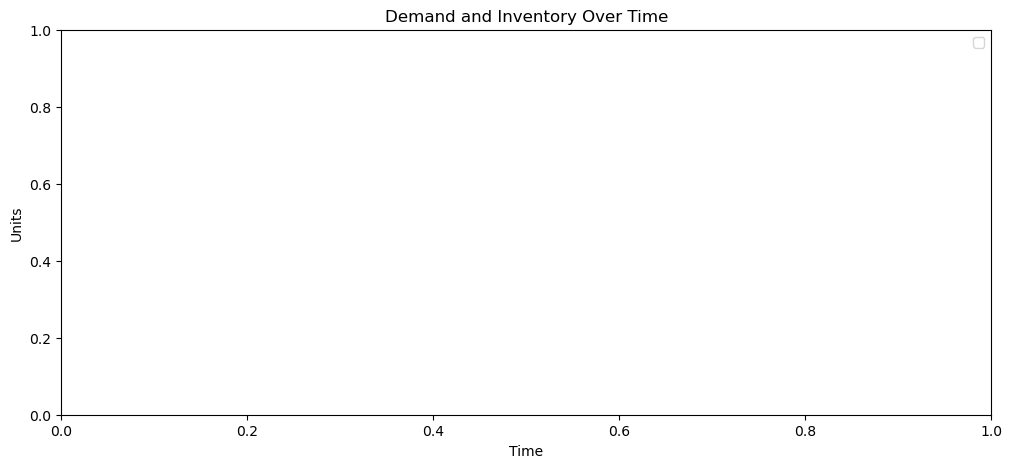

In [31]:
# Example EDA: Plot demand and inventory trends
plt.figure(figsize=(12,5))
if 'demand' in df.columns:
    plt.plot(df['demand'], label='Demand')
if 'inventory' in df.columns:
    plt.plot(df['inventory'], label='Inventory')
plt.legend()
plt.title('Demand and Inventory Over Time')
plt.xlabel('Time')
plt.ylabel('Units')
plt.show()

In [32]:
# Convert Date column to datetime (if not already done)
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# List of dates to remove
dates_to_remove = ['2022-12-28', '2019-01-01']
dates_to_remove = pd.to_datetime(dates_to_remove)

# Remove rows with those dates
df = df[~df['Date'].isin(dates_to_remove)]

# Optional: confirm removal
print("✅ Dates removed. Remaining rows:", len(df))


✅ Dates removed. Remaining rows: 91276


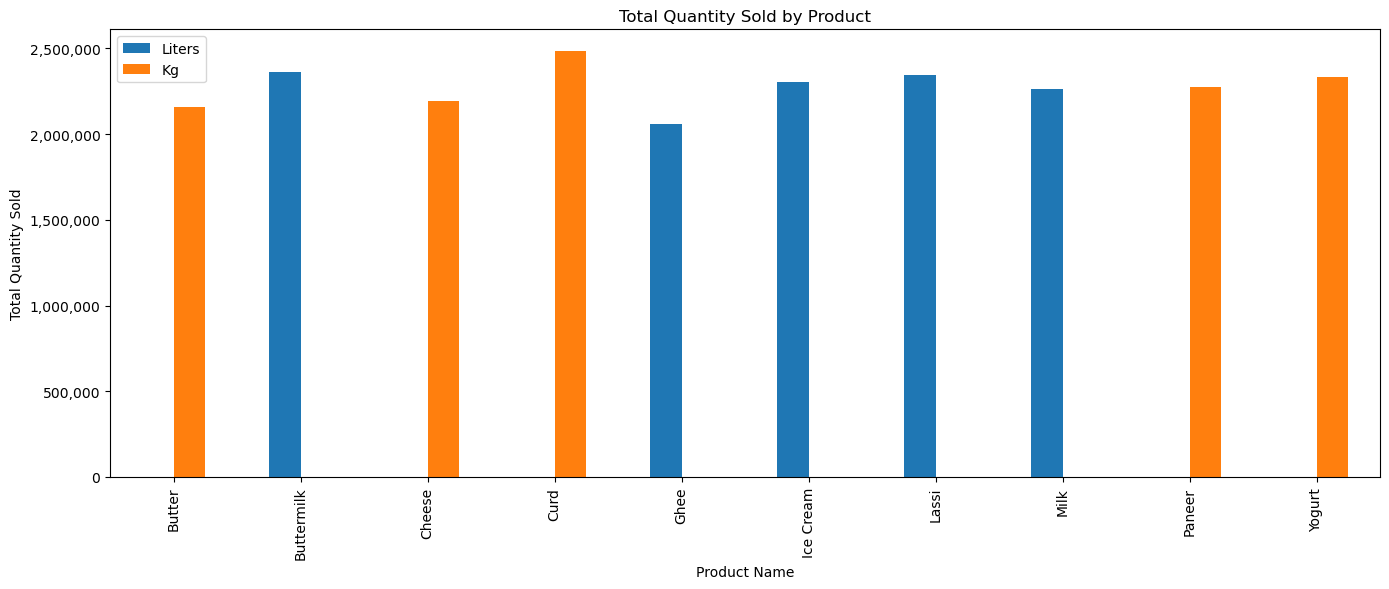

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Grouping and plotting
product_sales = df.groupby('Product Name')[['Quantity Sold (liters)', 'Quantity Sold (kg)']].sum()

# Plot
ax = product_sales.plot(kind='bar', figsize=(14, 6))

# Labels and Title
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Product')
plt.legend(['Liters', 'Kg'])

# Disable scientific notation on y-axis
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Optional: Customize tick intervals
# ax.yaxis.set_ticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000])

plt.tight_layout()
plt.show()


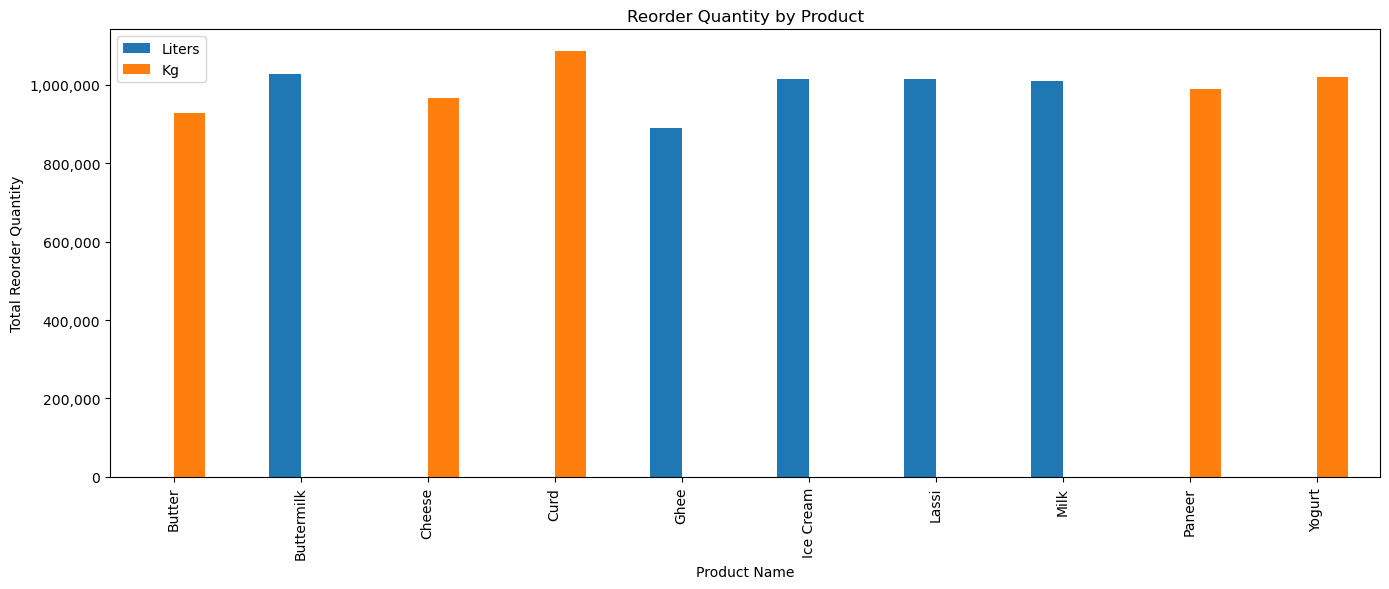

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Group by Product Name and sum reorder quantities
product_sales = df.groupby('Product Name')[['Reorder Quantity (liters)', 'Reorder Quantity (kg)']].sum()

# Plot
ax = product_sales.plot(kind='bar', figsize=(14,6))

# Add axis labels and title
plt.xlabel('Product Name')
plt.ylabel('Total Reorder Quantity')
plt.title('Reorder Quantity by Product')
plt.legend(['Liters', 'Kg'])

# Disable scientific notation on y-axis
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Optional: manually set tick marks (optional, adjust as needed)
# ax.yaxis.set_ticks([0, 200000, 400000, 600000, 800000, 1000000, 1200000])

plt.tight_layout()
plt.show()


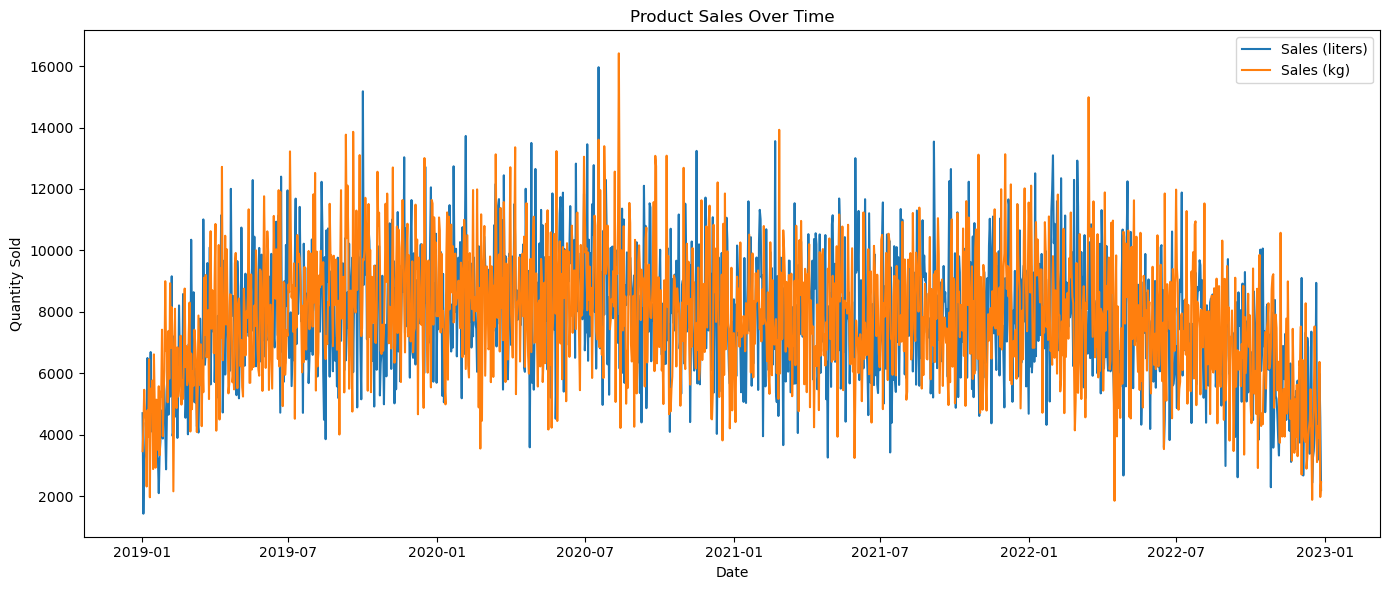

In [35]:
# Line plot: Product sales over time

# Make sure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Group by Date and sum Quantity Sold (liters) and Quantity Sold (kg)
sales_over_time = df.groupby('Date')[['Quantity Sold (liters)', 'Quantity Sold (kg)']].sum()

plt.figure(figsize=(14,6))
plt.plot(sales_over_time.index, sales_over_time['Quantity Sold (liters)'], label='Sales (liters)')
plt.plot(sales_over_time.index, sales_over_time['Quantity Sold (kg)'], label='Sales (kg)')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Product Sales Over Time')
plt.legend()
plt.tight_layout()
plt.show()

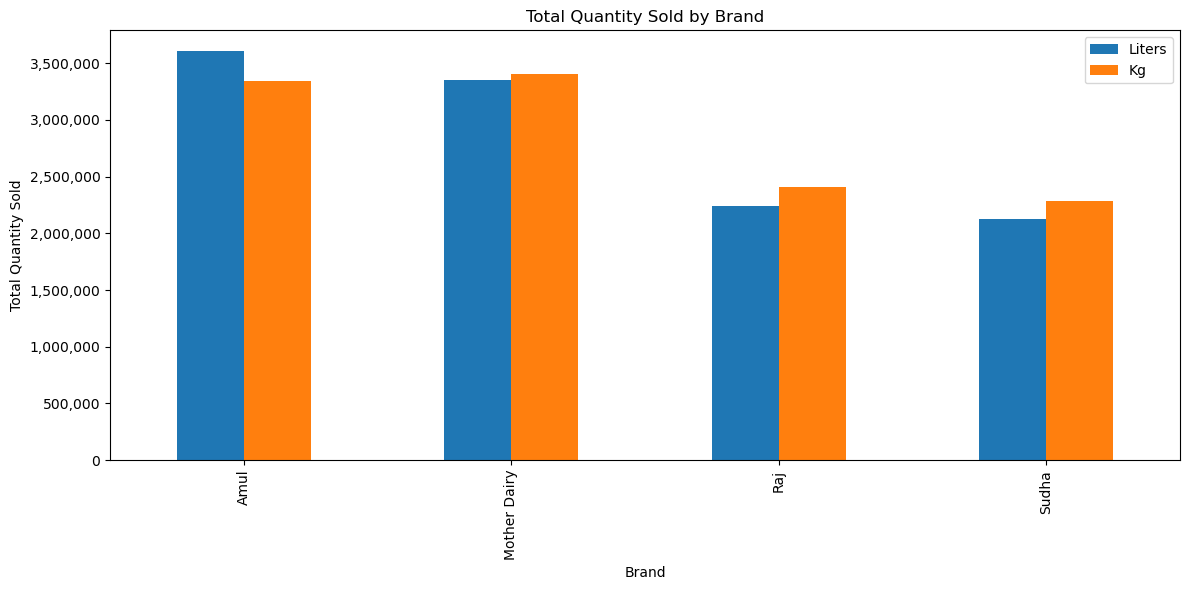

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Group by Brand and sum quantities (liters and kg)
brand_sales = df.groupby('Brand')[['Quantity Sold (liters)', 'Quantity Sold (kg)']].sum()

# Plot
ax = brand_sales.plot(kind='bar', figsize=(12,6))

# Labels and title
plt.xlabel('Brand')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Brand')
plt.legend(['Liters', 'Kg'])

# Format y-axis labels to regular integers
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()


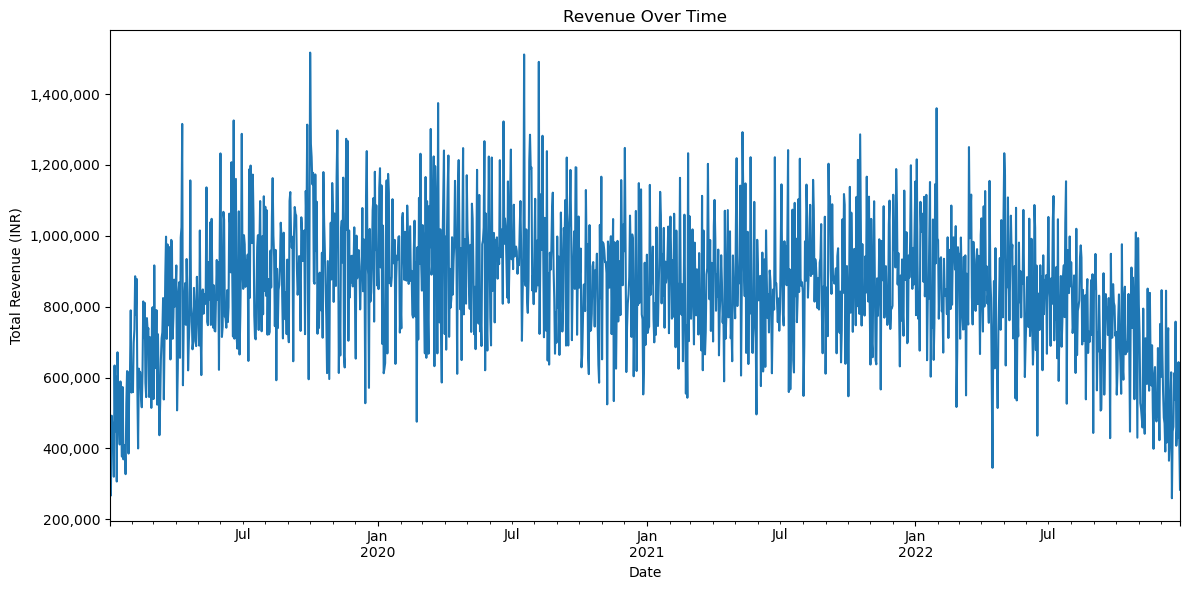

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Ensure datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Group and plot
fig, ax = plt.subplots(figsize=(12, 6))
df.groupby('Date')['Approx. Total Revenue(INR)'].sum().plot(ax=ax)

# Title and axis labels
ax.set_title("Revenue Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Total Revenue (INR)")

# Format y-axis to plain numbers (no scientific notation)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()


In [38]:
import pandas as pd

# Step 1: Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Group by Date and calculate total daily revenue
daily_revenue = df.groupby('Date')['Approx. Total Revenue(INR)'].sum()

# Step 3: Get top 10 dates with highest revenue
top_10_revenue = daily_revenue.nlargest(10)

# Step 4A: Print formatted top 10 list
print("📅 Top 10 Revenue Days (Formatted):")
for date, value in top_10_revenue.items():
    print(f"{date.date()}: ₹{value:,.0f}")

# Step 4B: Create and display formatted DataFrame
top_10_df = top_10_revenue.reset_index()
top_10_df.columns = ['Date', 'Revenue']
top_10_df['Revenue'] = top_10_df['Revenue'].apply(lambda x: f"₹{x:,.0f}")

print("\n📊 Top 10 Revenue Days Table:")
print(top_10_df.to_string(index=False))


📅 Top 10 Revenue Days (Formatted):
2019-10-01: ₹1,517,109
2020-07-18: ₹1,511,781
2020-08-07: ₹1,490,973
2020-03-23: ₹1,374,634
2022-01-30: ₹1,360,097
2019-06-19: ₹1,325,680
2020-06-20: ₹1,322,902
2019-04-10: ₹1,315,811
2019-09-27: ₹1,313,813
2020-03-13: ₹1,301,639

📊 Top 10 Revenue Days Table:
      Date    Revenue
2019-10-01 ₹1,517,109
2020-07-18 ₹1,511,781
2020-08-07 ₹1,490,973
2020-03-23 ₹1,374,634
2022-01-30 ₹1,360,097
2019-06-19 ₹1,325,680
2020-06-20 ₹1,322,902
2019-04-10 ₹1,315,811
2019-09-27 ₹1,313,813
2020-03-13 ₹1,301,639


In [39]:
import pandas as pd

# Step 1: Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Group by Date and calculate total daily revenue
daily_revenue = df.groupby('Date')['Approx. Total Revenue(INR)'].sum()

# Step 3: Get bottom 10 dates with lowest revenue
bottom_10_revenue = daily_revenue.nsmallest(10)

# Step 4A: Print formatted bottom 10 list
print("📉 Bottom 10 Revenue Days (Formatted):")
for date, value in bottom_10_revenue.items():
    print(f"{date.date()}: ₹{value:,.0f}")

# Step 4B: Create and display formatted DataFrame
bottom_10_df = bottom_10_revenue.reset_index()
bottom_10_df.columns = ['Date', 'Revenue']
bottom_10_df['Revenue'] = bottom_10_df['Revenue'].apply(lambda x: f"₹{x:,.0f}")

print("\n📊 Bottom 10 Revenue Days Table:")
print(bottom_10_df.to_string(index=False))


📉 Bottom 10 Revenue Days (Formatted):
2022-12-16: ₹259,444
2019-01-03: ₹267,083
2022-12-27: ₹283,441
2019-01-11: ₹306,624
2019-01-07: ₹320,176
2019-01-23: ₹327,422
2022-04-16: ₹345,269
2022-12-12: ₹365,382
2019-01-20: ₹369,238
2019-01-18: ₹376,942

📊 Bottom 10 Revenue Days Table:
      Date  Revenue
2022-12-16 ₹259,444
2019-01-03 ₹267,083
2022-12-27 ₹283,441
2019-01-11 ₹306,624
2019-01-07 ₹320,176
2019-01-23 ₹327,422
2022-04-16 ₹345,269
2022-12-12 ₹365,382
2019-01-20 ₹369,238
2019-01-18 ₹376,942


📊 Revenue Range Distribution:
Approx. Total Revenue(INR)
0–1L          0
1L–5L        49
5L–10L     1110
10L–20L     297
20L–50L       0
Name: count, dtype: int64


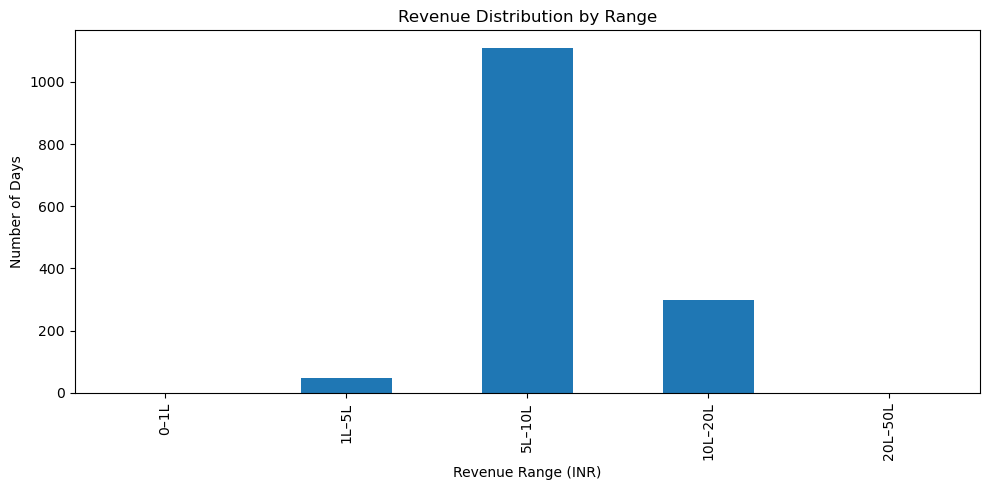

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Group by date and sum revenue
daily_revenue = df.groupby('Date')['Approx. Total Revenue(INR)'].sum()

# Step 3: Calculate max revenue and make sure bins are valid
max_revenue = daily_revenue.max()
upper_bin = max(max_revenue + 1, 3.1e7)  # Ensure final bin > 3e7

# Step 4: Define bins and labels
bins = [0, 1e5, 5e5, 1e6, 2e6, upper_bin]
labels = [
    "0–1L", "1L–5L", "5L–10L", "10L–20L", "20L–50L"
]

# Step 5: Apply binning
binned = pd.cut(daily_revenue, bins=bins, labels=labels, include_lowest=True)

# Step 6: Count entries in each range
range_counts = binned.value_counts().sort_index()

# Step 7: Display
print("📊 Revenue Range Distribution:")
print(range_counts)

# Optional: Plot it
range_counts.plot(kind='bar', title='Revenue Distribution by Range', figsize=(10,5))
plt.xlabel("Revenue Range (INR)")
plt.ylabel("Number of Days")
plt.tight_layout()
plt.show()


In [41]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])

Total rows: 91276
Total columns: 22


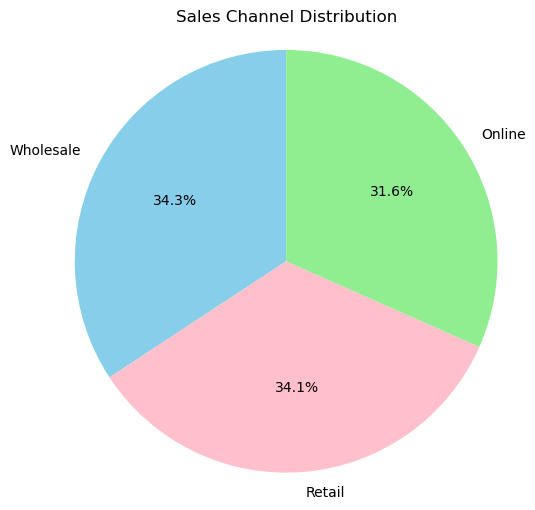

In [42]:
# Count sales by Sales Channel
channel_counts = df['Sales Channel'].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'pink', 'lightgreen'])
plt.title('Sales Channel Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

In [43]:
df.head()

,Date,Product ID,Product Name,Brand,Price per Unit,Total Value,Shelf Life (days),Production Date,Price per Unit (sold),Approx. Total Revenue(INR),...,Quantity (liters),Quantity (kg),Quantity Sold (liters),Quantity Sold (kg),Quantity in Stock (liters),Quantity in Stock (kg),Minimum Stock Threshold (liters),Minimum Stock Threshold (kg),Reorder Quantity (liters),Reorder Quantity (kg)
0,2019-10-19,4.541257,Cheese,Mother Dairy,25.772650,12227.972793,6,2019-10-06,25.835327,1081.085095,...,0.000000,474.455402,0.000000,41.845226,0.000000,432.610176,0.000000,53.946619,0.000000,125.168698
2,2021-01-12,3.600437,Butter,Amul,54.787795,15009.424375,22,2020-12-07,53.428623,2117.356759,...,0.000000,273.955620,0.000000,39.629634,0.000000,234.325986,0.000000,74.964513,0.000000,170.349551
4,2021-09-24,8.732560,Butter,Sudha,18.013273,14379.159594,112,2021-08-24,17.713561,6185.441550,...,0.000000,798.253557,0.000000,349.192441,0.000000,449.061116,0.000000,64.424322,0.000000,164.690946
5,2019-09-29,10.000000,Ghee,Amul,95.169570,39226.991586,140,2019-09-20,92.244630,3010.228683,...,412.179982,0.000000,32.633105,0.000000,379.546878,0.000000,90.584562,0.000000,135.949577,0.000000
6,2020-06-07,1.000000,Cheese,Amul,24.250181,9458.978125,7,2020-04-23,19.001828,1486.415941,...,0.000000,390.058041,0.000000,78.224892,0.000000,311.833149,0.000000,17.115167,0.000000,20.020000


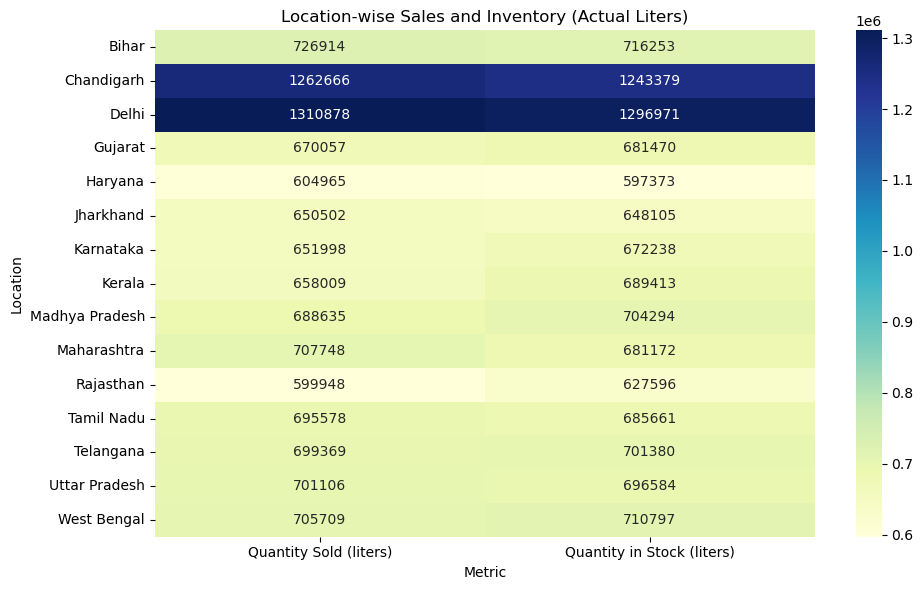

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and sum
heatmap_data = df.groupby('Customer Location')[['Quantity Sold (liters)', 'Quantity in Stock (liters)']].sum()

# Plot without normalization
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu', cbar=True)
plt.title('Location-wise Sales and Inventory (Actual Liters)')
plt.ylabel('Location')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


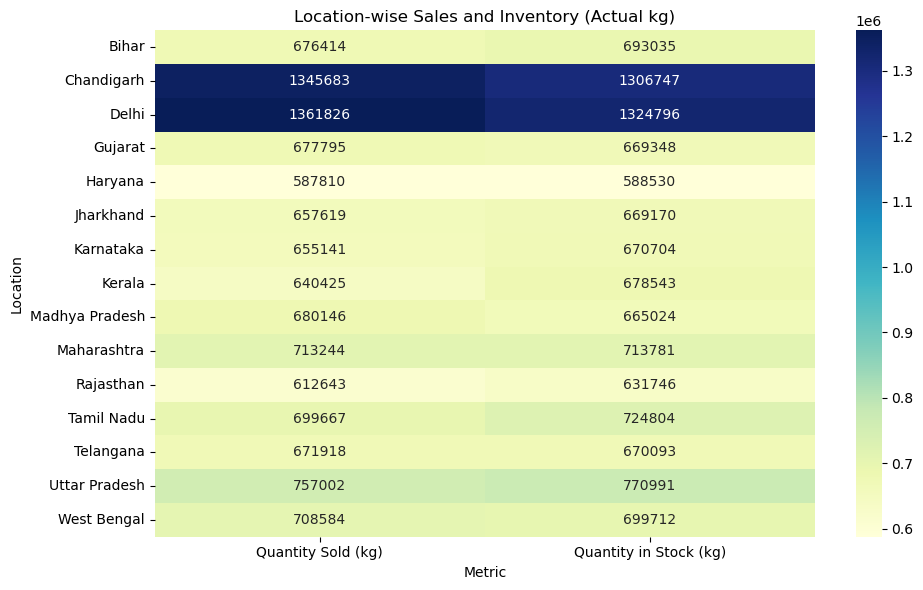

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and sum
heatmap_data = df.groupby('Customer Location')[['Quantity Sold (kg)', 'Quantity in Stock (kg)']].sum()

# Plot without normalization
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu', cbar=True)
plt.title('Location-wise Sales and Inventory (Actual kg)')
plt.ylabel('Location')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


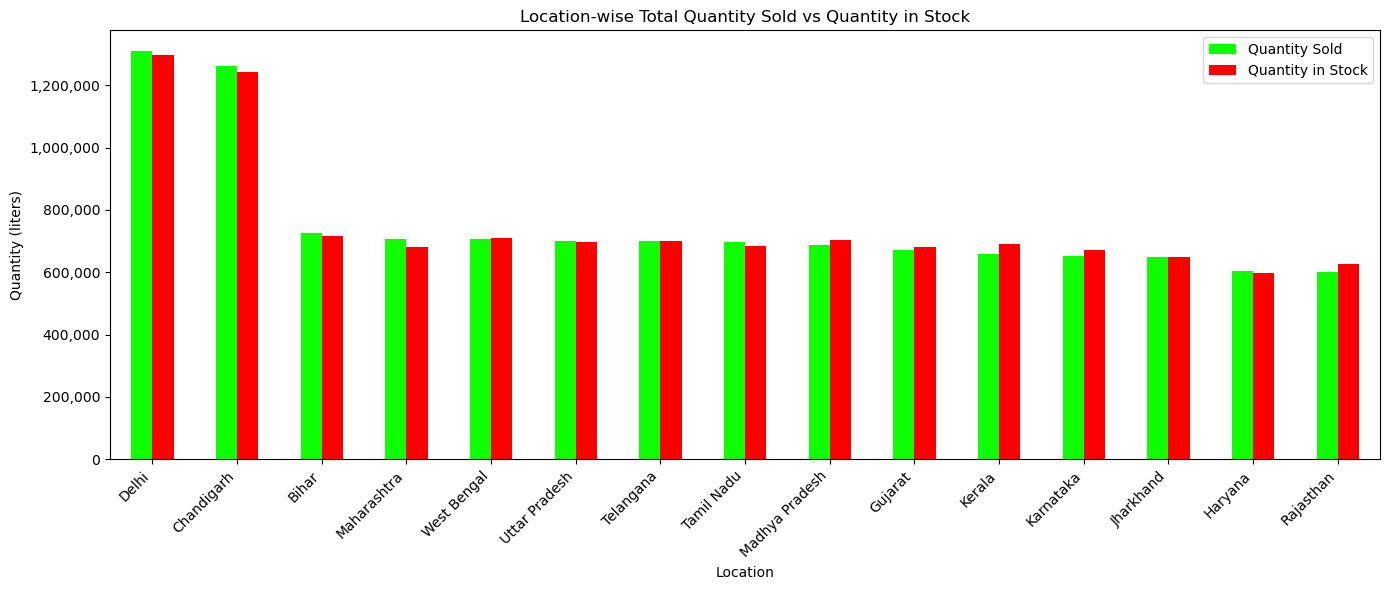

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Group by Location and sum quantities
location_summary = df.groupby('Customer Location')[['Quantity Sold (liters)', 'Quantity in Stock (liters)']].sum()

# Sort for better display
location_summary = location_summary.sort_values('Quantity Sold (liters)', ascending=False)

# Plot with custom colors
ax = location_summary.plot(
    kind='bar',
    figsize=(14,6),
    color=["#0eff02", "#fc0000"]  # Blue for Sold, Orange for Stock
)

# Format y-axis to show full numbers
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.title('Location-wise Total Quantity Sold vs Quantity in Stock')
plt.xlabel('Location')
plt.ylabel('Quantity (liters)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Quantity Sold', 'Quantity in Stock'])
plt.tight_layout()
plt.show()


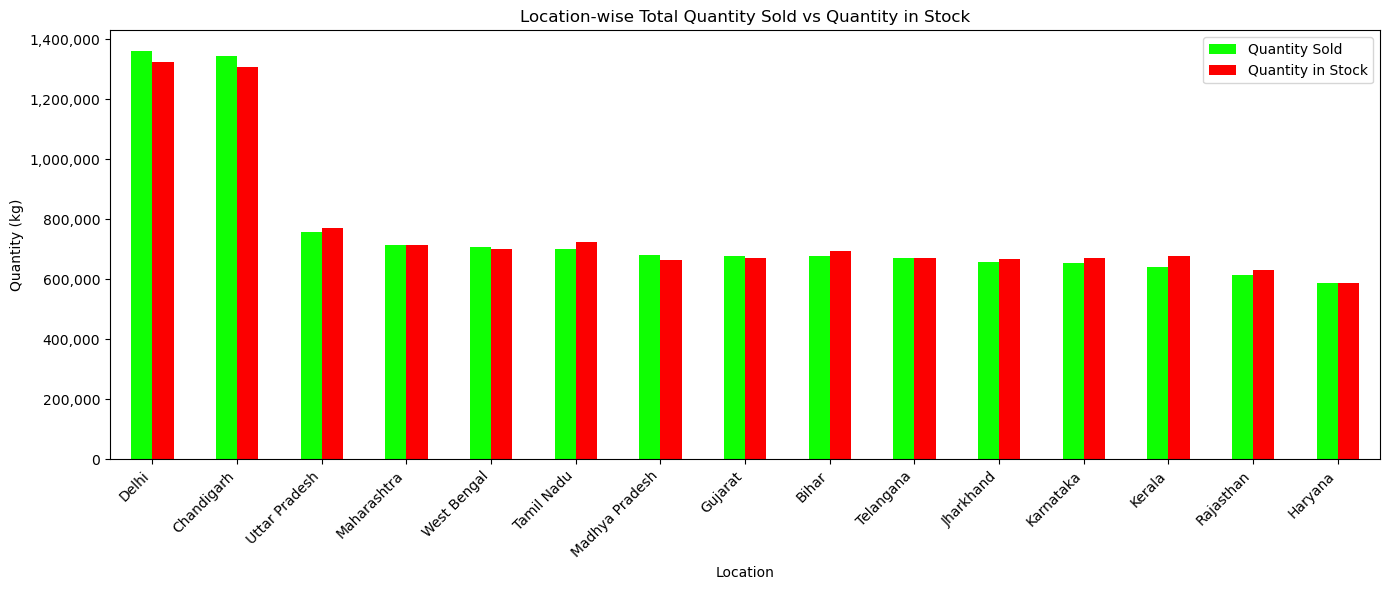

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Group by Location and sum quantities
location_summary = df.groupby('Customer Location')[['Quantity Sold (kg)', 'Quantity in Stock (kg)']].sum()

# Sort for better display
location_summary = location_summary.sort_values('Quantity Sold (kg)', ascending=False)

# Plot with custom colors
ax = location_summary.plot(
    kind='bar',
    figsize=(14,6),
    color=['#0eff02', '#fc0000']  # Blue for Sold, Orange for Stock
)

# Format y-axis to show full numbers
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.title('Location-wise Total Quantity Sold vs Quantity in Stock')
plt.xlabel('Location')
plt.ylabel('Quantity (kg)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Quantity Sold', 'Quantity in Stock'])
plt.tight_layout()
plt.show()


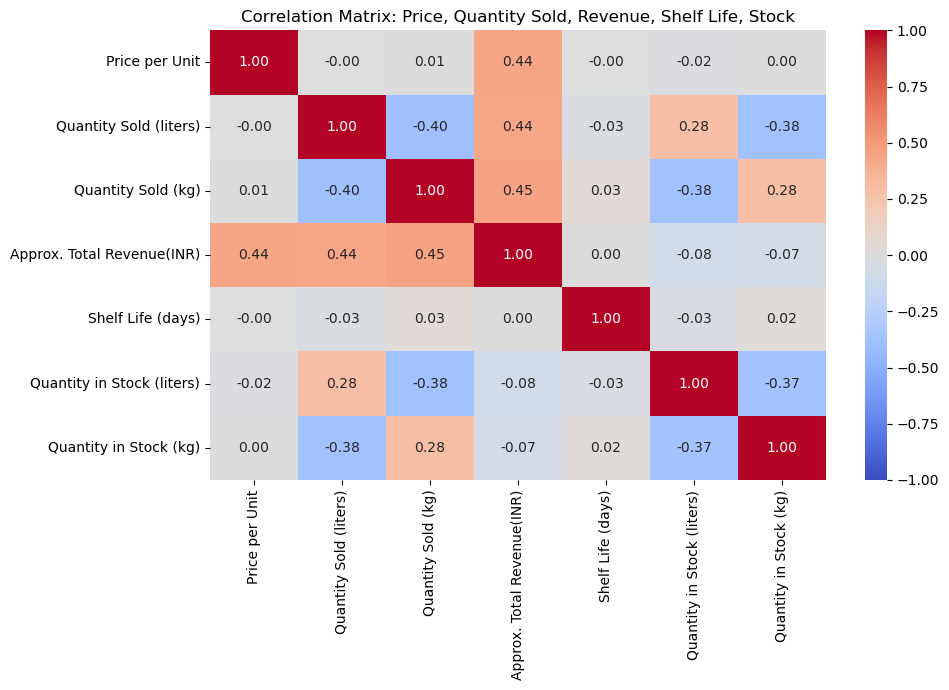

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure all selected columns exist in the DataFrame
corr_cols = [
    'Price per Unit', 
    'Quantity Sold (liters)', 
    'Quantity Sold (kg)', 
    'Approx. Total Revenue(INR)', 
    'Shelf Life (days)', 
    'Quantity in Stock (liters)', 
    'Quantity in Stock (kg)'
]
corr_cols = [col for col in corr_cols if col in df.columns]

# Ensure data is numeric and clean
df_clean = df[corr_cols].copy()
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, force errors to NaN
df_clean = df_clean.dropna()  # Drop rows with NaN

# Compute correlation matrix
corr_matrix = df_clean.corr(method='pearson')  # Pearson is default but shown explicitly here

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix: Price, Quantity Sold, Revenue, Shelf Life, Stock')
plt.tight_layout()
plt.show()


In [49]:
# one hot encode 'Brand' column
df = pd.get_dummies(df, columns=['Brand'], prefix='Brand')

# one hot encode 'Product Name' column
df = pd.get_dummies(df, columns=['Product Name'], prefix='Product Name')

# one hot encode 'Customer Location' column
df = pd.get_dummies(df, columns=['Customer Location'], prefix='Customer Location')
# one hot encode 'Sales Channel' column
df = pd.get_dummies(df, columns=['Sales Channel'], prefix='Sales Channel')

# Convert all boolean columns to integers (0/1)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [50]:
print(df.columns.tolist())

['Date', 'Product ID', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Production Date', 'Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Quantity (liters)', 'Quantity (kg)', 'Quantity Sold (liters)', 'Quantity Sold (kg)', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)', 'Brand_Amul', 'Brand_Mother Dairy', 'Brand_Raj', 'Brand_Sudha', 'Product Name_Butter', 'Product Name_Buttermilk', 'Product Name_Cheese', 'Product Name_Curd', 'Product Name_Ghee', 'Product Name_Ice Cream', 'Product Name_Lassi', 'Product Name_Milk', 'Product Name_Paneer', 'Product Name_Yogurt', 'Customer Location_Bihar', 'Customer Location_Chandigarh', 'Customer Location_Delhi', 'Customer Location_Gujarat', 'Customer Location_Haryana', 'Customer Location_Jharkhand', 'Customer Location_Karnataka', 'Customer Location_Kerala', 'Customer Location_Madhya Pradesh', 'Customer Location_Ma

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91276 entries, 0 to 122982
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              91276 non-null  datetime64[ns]
 1   Product ID                        91276 non-null  float64       
 2   Price per Unit                    91276 non-null  float64       
 3   Total Value                       91276 non-null  float64       
 4   Shelf Life (days)                 91276 non-null  int32         
 5   Production Date                   91276 non-null  datetime64[ns]
 6   Price per Unit (sold)             91276 non-null  float64       
 7   Approx. Total Revenue(INR)        91276 non-null  float64       
 8   Quantity (liters)                 91276 non-null  float64       
 9   Quantity (kg)                     91276 non-null  float64       
 10  Quantity Sold (liters)            91276 non-null  

In [52]:
'''
# Step 1: Convert to datetime (if not already)
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df['Production Date'] = pd.to_datetime(df['Production Date'], errors='coerce')

# Step 2: Create new date-related features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

df['Production_Year'] = df['Production Date'].dt.year
df['Production_Month'] = df['Production Date'].dt.month
df['Production_Age_Days'] = (df['Date'] - df['Production Date']).dt.days

df.info()
'''

"\n# Step 1: Convert to datetime (if not already)\n# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')\n# df['Production Date'] = pd.to_datetime(df['Production Date'], errors='coerce')\n\n# Step 2: Create new date-related features\ndf['Day'] = df['Date'].dt.day\ndf['Month'] = df['Date'].dt.month\ndf['Year'] = df['Date'].dt.year\ndf['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6\n\ndf['Production_Year'] = df['Production Date'].dt.year\ndf['Production_Month'] = df['Production Date'].dt.month\ndf['Production_Age_Days'] = (df['Date'] - df['Production Date']).dt.days\n\ndf.info()\n"

In [53]:
print(df.columns.tolist())

['Date', 'Product ID', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Production Date', 'Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Quantity (liters)', 'Quantity (kg)', 'Quantity Sold (liters)', 'Quantity Sold (kg)', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)', 'Brand_Amul', 'Brand_Mother Dairy', 'Brand_Raj', 'Brand_Sudha', 'Product Name_Butter', 'Product Name_Buttermilk', 'Product Name_Cheese', 'Product Name_Curd', 'Product Name_Ghee', 'Product Name_Ice Cream', 'Product Name_Lassi', 'Product Name_Milk', 'Product Name_Paneer', 'Product Name_Yogurt', 'Customer Location_Bihar', 'Customer Location_Chandigarh', 'Customer Location_Delhi', 'Customer Location_Gujarat', 'Customer Location_Haryana', 'Customer Location_Jharkhand', 'Customer Location_Karnataka', 'Customer Location_Kerala', 'Customer Location_Madhya Pradesh', 'Customer Location_Ma

# Feature Engineering and Train-Test Split
Select relevant features and split the data into training and testing sets for model development.

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Select only numeric features and drop target columns
features = df.select_dtypes(include=[np.number]).drop(columns=['Quantity Sold (liters)', 'Quantity Sold (kg)','Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Total Value', 'Product ID', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)' ], errors='ignore')
feature_names = features.columns.tolist()
print("Model input features:", feature_names)
# Step 2: Define the target (multi-output)
target = df[['Quantity Sold (liters)', 'Quantity Sold (kg)']]  # double brackets for DataFrame

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Step 4: Print shape summary
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)


Model input features: ['Price per Unit', 'Shelf Life (days)', 'Quantity (liters)', 'Quantity (kg)', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)', 'Brand_Amul', 'Brand_Mother Dairy', 'Brand_Raj', 'Brand_Sudha', 'Product Name_Butter', 'Product Name_Buttermilk', 'Product Name_Cheese', 'Product Name_Curd', 'Product Name_Ghee', 'Product Name_Ice Cream', 'Product Name_Lassi', 'Product Name_Milk', 'Product Name_Paneer', 'Product Name_Yogurt', 'Customer Location_Bihar', 'Customer Location_Chandigarh', 'Customer Location_Delhi', 'Customer Location_Gujarat', 'Customer Location_Haryana', 'Customer Location_Jharkhand', 'Customer Location_Karnataka', 'Customer Location_Kerala', 'Customer Location_Madhya Pradesh', 'Customer Location_Maharashtra', 'Customer Location_Rajasthan', 'Customer Location_Tamil Nadu', 'Customer Location_Telangana', 'Customer Location_Uttar Pradesh', 'Customer Location_West Bengal', 'Sales Channel_Online', 'Sales 

# Model Training
Train a Random Forest Regressor to predict demand based on selected features.

In [55]:
# Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print('Model training complete.')

Model training complete.


# Model Evaluation
Evaluate the model's performance using RMSE and R² metrics.

In [56]:
import sklearn
print(sklearn.__version__)

1.5.1


In [57]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

# If y_test is a DataFrame with more than one column (multi-output)
if hasattr(y_test, "columns") and len(y_test.columns) > 1:
    for i, column in enumerate(y_test.columns):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = mse ** 0.5
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f'[{column}] → RMSE: {rmse:.2f} | R² Score: {r2:.2f}')
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')

[Quantity Sold (liters)] → RMSE: 2.67 | R² Score: 1.00
[Quantity Sold (kg)] → RMSE: 2.12 | R² Score: 1.00


# Saumil Jani Code For Over Fitting Check 

In [58]:

from sklearn.metrics import mean_squared_error, r2_score

# --- Your Existing Code ---
y_pred = model.predict(X_test)
print("Prediction shape:",y_pred.shape)
# If y_test is a DataFrame with more than one column (multi-output)
if hasattr(y_test, "columns") and len(y_test.columns) > 1:
    for i, column in enumerate(y_test.columns):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = mse ** 0.5
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f'[{column}] → RMSE: {rmse:.2f} | R² Score: {r2:.2f}')
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')


# --- 🔍 ADD THIS PART to check for overfitting ---
# Compare training vs testing performance (for single-output only)

print("\n----- Overfitting Check (Training vs Testing Performance) -----")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# If multi-output, skip detailed comparison
if hasattr(y_test, "columns") and len(y_test.columns) > 1:
    for i, column in enumerate(y_test.columns):
        y_train_col = y_train.iloc[:, i]
        y_train_pred_col = model.predict(X_train)[:, i]
        y_test_col = y_test.iloc[:, i]
        y_test_pred_col = y_test_pred[:, i]

        train_rmse = mean_squared_error(y_train_col, y_train_pred_col) ** 0.5
        train_r2 = r2_score(y_train_col, y_train_pred_col)

        test_rmse = mean_squared_error(y_test_col, y_test_pred_col) ** 0.5
        test_r2 = r2_score(y_test_col, y_test_pred_col)

        print(f"[{column}] → Training RMSE: {train_rmse:.2f}, R²: {train_r2:.2f} | "
              f"Testing RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")
else:
    train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
    train_r2 = r2_score(y_train, y_train_pred)

    test_rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
    print(f"Testing  RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


Prediction shape: (27383, 2)
[Quantity Sold (liters)] → RMSE: 2.67 | R² Score: 1.00
[Quantity Sold (kg)] → RMSE: 2.12 | R² Score: 1.00

----- Overfitting Check (Training vs Testing Performance) -----
[Quantity Sold (liters)] → Training RMSE: 0.92, R²: 1.00 | Testing RMSE: 2.67, R²: 1.00
[Quantity Sold (kg)] → Training RMSE: 0.87, R²: 1.00 | Testing RMSE: 2.12, R²: 1.00


# Demand Forecasting and Inventory Optimization
Use the trained model to forecast future demand and optimize inventory levels accordingly.

In [59]:
'''
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

# ======== USER INPUTS =========
forecast_days = int(input("Enter how many future rows to forecast (e.g. 7): "))
check_mode = input("Check inventory for: 'liters', 'kg', or 'both'? ").strip().lower()

# ======== PREDICT FUTURE DEMAND =========
future_features = X_test.iloc[:forecast_days].copy()
future_preds = model.predict(future_features)  # shape: (n_days, 2)

future_df = future_features.copy()
future_df['Predicted_Liters'] = future_preds[:, 0]
future_df['Predicted_KG'] = future_preds[:, 1]

# ======== DETECT PRODUCT & BRAND NAMES =========
product_cols = [col for col in df.columns if col.startswith('Product Name_')]
brand_cols = [col for col in df.columns if col.startswith('Brand_')]

future_df['Product'] = future_df[product_cols].idxmax(axis=1).str.replace('Product Name_', '')
future_df['Brand'] = future_df[brand_cols].idxmax(axis=1).str.replace('Brand_', '')

# ======== GROUP FORECASTED DEMAND =========
forecast_grouped = future_df.groupby(['Brand', 'Product'])[['Predicted_Liters', 'Predicted_KG']].sum()

# ======== GET LATEST STOCK =========
stock_df = df.copy()
stock_df['Product'] = df[product_cols].idxmax(axis=1).str.replace('Product Name_', '')
stock_df['Brand'] = df[brand_cols].idxmax(axis=1).str.replace('Brand_', '')

latest_stock = stock_df.groupby(['Brand', 'Product'])[['Quantity in Stock (liters)', 'Quantity in Stock (kg)']].last()

# ======== REORDER CHECK =========
print("\n📦 Reorder Check by Brand & Product:")

for (brand, product), forecast in forecast_grouped.iterrows():
    liters_demand = forecast['Predicted_Liters']
    kg_demand = forecast['Predicted_KG']
    reorder_liters = liters_demand * 1.1
    reorder_kg = kg_demand * 1.1

    # Get stock for this brand+product
    if (brand, product) in latest_stock.index:
        stock_row = latest_stock.loc[(brand, product)]
        liters_stock = stock_row['Quantity in Stock (liters)']
        kg_stock = stock_row['Quantity in Stock (kg)']
    else:
        liters_stock = np.nan
        kg_stock = np.nan

    print(f"\n🧾 {brand} → {product}")

    # Liters check
    if check_mode in ['liters', 'both'] and liters_demand > 0:
        if pd.isna(liters_stock):
            print("  ⚠️ No stock data for liters.")
        elif liters_stock < reorder_liters:
            print(f"  🔺 Reorder (liters): Need {reorder_liters:.2f}, Stock {liters_stock:.2f}")
        else:
            print(f"  ✅ Liters stock is sufficient.")

    # KG check
    if check_mode in ['kg', 'both'] and kg_demand > 0:
        if pd.isna(kg_stock):
            print("  ⚠️ No stock data for kg.")
        elif kg_stock < reorder_kg:
            print(f"  🔺 Reorder (kg): Need {reorder_kg:.2f}, Stock {kg_stock:.2f}")
        else:
            print(f"  ✅ KG stock is sufficient.")
'''

'\nimport numpy as np\nimport pandas as pd\n\nfrom sklearn.metrics import mean_squared_error, r2_score\n\n# ======== USER INPUTS =========\nforecast_days = int(input("Enter how many future rows to forecast (e.g. 7): "))\ncheck_mode = input("Check inventory for: \'liters\', \'kg\', or \'both\'? ").strip().lower()\n\n# ======== PREDICT FUTURE DEMAND =========\nfuture_features = X_test.iloc[:forecast_days].copy()\nfuture_preds = model.predict(future_features)  # shape: (n_days, 2)\n\nfuture_df = future_features.copy()\nfuture_df[\'Predicted_Liters\'] = future_preds[:, 0]\nfuture_df[\'Predicted_KG\'] = future_preds[:, 1]\n\n# ======== DETECT PRODUCT & BRAND NAMES =========\nproduct_cols = [col for col in df.columns if col.startswith(\'Product Name_\')]\nbrand_cols = [col for col in df.columns if col.startswith(\'Brand_\')]\n\nfuture_df[\'Product\'] = future_df[product_cols].idxmax(axis=1).str.replace(\'Product Name_\', \'\')\nfuture_df[\'Brand\'] = future_df[brand_cols].idxmax(axis=1).str.

# Pickle File Generation 

In [60]:
import pickle

# Save model to a file
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved as model.pkl")


✅ Model saved as model.pkl


In [61]:
# Inspect dataset columns and sample data
print('Columns:', df.columns.tolist())
df.head()

Columns: ['Date', 'Product ID', 'Price per Unit', 'Total Value', 'Shelf Life (days)', 'Production Date', 'Price per Unit (sold)', 'Approx. Total Revenue(INR)', 'Quantity (liters)', 'Quantity (kg)', 'Quantity Sold (liters)', 'Quantity Sold (kg)', 'Quantity in Stock (liters)', 'Quantity in Stock (kg)', 'Minimum Stock Threshold (liters)', 'Minimum Stock Threshold (kg)', 'Reorder Quantity (liters)', 'Reorder Quantity (kg)', 'Brand_Amul', 'Brand_Mother Dairy', 'Brand_Raj', 'Brand_Sudha', 'Product Name_Butter', 'Product Name_Buttermilk', 'Product Name_Cheese', 'Product Name_Curd', 'Product Name_Ghee', 'Product Name_Ice Cream', 'Product Name_Lassi', 'Product Name_Milk', 'Product Name_Paneer', 'Product Name_Yogurt', 'Customer Location_Bihar', 'Customer Location_Chandigarh', 'Customer Location_Delhi', 'Customer Location_Gujarat', 'Customer Location_Haryana', 'Customer Location_Jharkhand', 'Customer Location_Karnataka', 'Customer Location_Kerala', 'Customer Location_Madhya Pradesh', 'Customer Lo

,Date,Product ID,Price per Unit,Total Value,Shelf Life (days),Production Date,Price per Unit (sold),Approx. Total Revenue(INR),Quantity (liters),Quantity (kg),...,Customer Location_Madhya Pradesh,Customer Location_Maharashtra,Customer Location_Rajasthan,Customer Location_Tamil Nadu,Customer Location_Telangana,Customer Location_Uttar Pradesh,Customer Location_West Bengal,Sales Channel_Online,Sales Channel_Retail,Sales Channel_Wholesale
0,2019-10-19,4.541257,25.772650,12227.972793,6,2019-10-06,25.835327,1081.085095,0.000000,474.455402,...,0,0,0,0,0,0,0,0,1,0
2,2021-01-12,3.600437,54.787795,15009.424375,22,2020-12-07,53.428623,2117.356759,0.000000,273.955620,...,0,0,0,0,0,0,0,0,1,0
4,2021-09-24,8.732560,18.013273,14379.159594,112,2021-08-24,17.713561,6185.441550,0.000000,798.253557,...,0,0,0,1,0,0,0,0,1,0
5,2019-09-29,10.000000,95.169570,39226.991586,140,2019-09-20,92.244630,3010.228683,412.179982,0.000000,...,0,0,0,0,0,0,0,0,1,0
6,2020-06-07,1.000000,24.250181,9458.978125,7,2020-04-23,19.001828,1486.415941,0.000000,390.058041,...,0,0,0,0,0,0,0,1,0,0


In [63]:
location_columns = [col for col in df.columns if col.startswith('Customer Location_')]
print("One-hot encoded location columns:", location_columns)
print("Number of non-zero entries in each:")
print(df[location_columns].sum())


One-hot encoded location columns: ['Customer Location_Bihar', 'Customer Location_Chandigarh', 'Customer Location_Delhi', 'Customer Location_Gujarat', 'Customer Location_Haryana', 'Customer Location_Jharkhand', 'Customer Location_Karnataka', 'Customer Location_Kerala', 'Customer Location_Madhya Pradesh', 'Customer Location_Maharashtra', 'Customer Location_Rajasthan', 'Customer Location_Tamil Nadu', 'Customer Location_Telangana', 'Customer Location_Uttar Pradesh', 'Customer Location_West Bengal']
Number of non-zero entries in each:
Customer Location_Bihar              5591
Customer Location_Chandigarh        10383
Customer Location_Delhi             10561
Customer Location_Gujarat            5352
Customer Location_Haryana            4714
Customer Location_Jharkhand          5278
Customer Location_Karnataka          5390
Customer Location_Kerala             5402
Customer Location_Madhya Pradesh     5486
Customer Location_Maharashtra        5630
Customer Location_Rajasthan          4928
Cu